# 뉴스 기사 요약해보기

In [1]:
# 프로젝트 준비, 라이브러리 임포트
from importlib.metadata import version
import re
import nltk
import tensorflow
import summa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import AdditiveAttention
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


## 데이터 수집

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
96845,Manipur govt decides to set up anti-corruption...,The BJP-led Manipur government has decided to ...
93244,Olympic champion swimmer competes while 6 mont...,Five-time Olympic gold medallist swimmer Dana ...
3465,India removes price cap on innovative drugs fo...,The government on Thursday removed the price c...
71597,I'm very happy: Ali on rumoured relationship w...,"Ali Fazal, while speaking about his rumoured r..."
10468,Drunk NRI falls from Delhi's Taj Mahal Hotel t...,A 48-year-old NRI businessman died after he ac...
65931,Designers walk for JJ Valaya's show on his 25 ...,"Fashion designers, including Ashish Soni and R..."
79875,What does the design of Karnataka's state flag...,The Karnataka state flag was designed by Kanna...
2327,Why do they pretend I don't exist? Kangana on ...,"Kangana Ranaut, while speaking about her conte..."
61839,Federer wins three awards at ATP World Tour Aw...,Swiss tennis star Roger Federer was given the ...
75523,American tourist beaten up for giving Nazi sal...,Police said a drunken American man was punched...


## 데이터 전처리 하기

### 결측치 확인 및 제거

In [4]:
# 결측치가 없다
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 중복 제거

In [5]:
# 결과에 깨진 글자가 있어서 점검, 
# 고유명사로 보이고, 나름 정확히 처리 되어서 pass
data.iloc[4900]['headlines'], data.iloc[4900]['text']

('PM Modi unveils projects worth over Ã¢Â\x82Â¹14,000 crore in Odisha',
 'PM Narendra Modi has inaugurated or laid foundation for projects worth over Ã¢Â\x82Â¹14,000 crore in Odisha, including a IIT Bhubaneswar campus that cost Ã¢Â\x82Â¹1,260 crore. He laid foundation for Indian Institutes of Science Education and Research campus which is estimated to cost Ã¢Â\x82Â¹1,583 crore. He also laid foundation for a Paradip-Hyderabad gas pipeline, that is expected to cost Ã¢Â\x82Â¹3,800 crore.')

In [6]:
# 중복 제거시 영향도 파악을 위한 갯수 확인
data.size, data['headlines'].nunique(), data['text'].nunique()

(196802, 98280, 98360)

In [7]:
# 원본 텍스트가 달라도 요약본이 동일할 수 있으므로, text의 중복을 제거한다.
data.drop_duplicates(subset = ['text'], inplace=True)
data.size

196720

### 텍스트 정규화

In [8]:
# 정규화 사전 추가
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


### 불용어 처리

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# nltk에 정의된 불용어 출력
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수: 불용어와 정규화를 일괄 진행
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 텍스트 정제
clean_text = list(map(preprocess_sentence, data['text']))
clean_text[:3]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history']

In [13]:
# 해드라인 정제
clean_headline = list(map(lambda x: preprocess_sentence(x, False), data['headlines']))
clean_headline[:3]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak']

In [14]:
# 정제된 텍스트 반영
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('Done')

Done


In [15]:
# 정제 이후 결측치 발생 여부 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


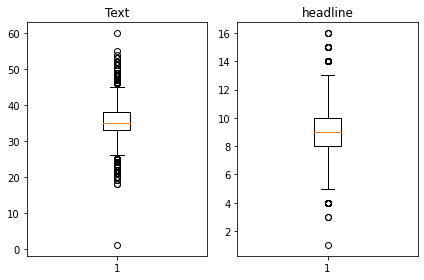

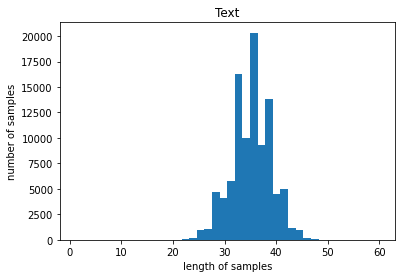

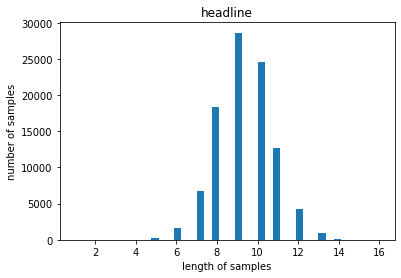

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
# 평균 보다 조금 높게 글자수 설정
text_max_len = 50
headlines_max_len = 14

In [19]:
# max 범위 점검, 커버리지 확인
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
    print(len(nested_list), cnt)
print('Done')

Done


In [20]:
# 함수 호출
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
98360 98346
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123
98360 98338


In [21]:
# min 범위 커버리지 확인
# 글자가 1개인 경우도 불필요하다고 봄

def above_threshold_len(min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) > min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))
    print(len(nested_list), cnt)
print('Done')

Done


In [22]:
# 함수 호출 및 결과 도출
min_text_len = 1
above_threshold_len(min_text_len, data['text'])
above_threshold_len(min_text_len,  data['headlines'])

전체 샘플 중 길이가 1 이하인 샘플의 비율: 0.9999898332655551
98360 98359
전체 샘플 중 길이가 1 이하인 샘플의 비율: 0.9999898332655551
98360 98359


In [23]:
# 데이터프레임에 반영
# min_text_len <= len(data.iloc[1,1].split()) <= text_max_len

data = data[data.apply(
    lambda x: (min_text_len < len(x['text'].split()) <= text_max_len) 
    and  (min_text_len < len(x['headlines'].split()) <= headlines_max_len), axis=1)]

print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98323


### 시작/종료 토큰 추가

In [24]:
# 시작/종료 토큰을 추가하고 새로운 열로 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [25]:
# 넘파이 배열로 변환
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('Done')

Done


### 테스트셋 나누기

In [26]:
# 순서를 섞기위한 인덱스 배열 생성후 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[94263  5982 74136 ... 21278 17955 65708]


In [27]:
# 셔플된 인덱스 배열로 인코더 및 디코더 데이터 재정렬
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('Done')

Done


In [28]:
# 테스트셋 단위 구성 20%가 테스트
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19664


In [29]:
# 테스트셋, 트레인셋 나눔
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78659
훈련 레이블의 개수 : 78659
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


### 단어 사전 및 정수 인코딩

In [30]:
# 케라스의 토크나이저를 생성하고, 이를 입력 데이터로 훈련시킴
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('Done')

Done


In [31]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69636
등장 빈도가 9번 이하인 희귀 단어의 수: 51241
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18395
단어 집합에서 희귀 단어의 비율: 73.58406571313688
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.558833863511725


In [32]:
# 중복 함수 정리를 위해 효율화
def analysis_voca(tokenizer, threshold):
    '''
    '''
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [33]:
# 함수 테스트
analysis_voca(src_tokenizer, 6)

# 정상적으로 동작
# 6회 이상 사용하지 않는 단어 확인

단어 집합(vocabulary)의 크기 : 69636
등장 빈도가 5번 이하인 희귀 단어의 수: 45682
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23954
단어 집합에서 희귀 단어의 비율: 65.6011258544431
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.0917815949978014


In [34]:
# 단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기가 24024
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 24000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('Done')

Done


In [35]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[282, 303, 9866, 2893, 4903, 10713, 131, 2658, 18, 194, 9866, 4903, 1247, 14285, 420, 351, 131, 139, 2658, 18, 1426, 75, 10483, 789, 17, 1005, 302, 15341, 5883], [2352, 553, 74, 55, 500, 542, 5215, 1, 10, 7349, 2745, 418, 18396, 418, 274, 393, 416, 1689, 6791, 9003, 119, 6879, 1631, 327, 105, 291, 4, 2352], [8558, 2220, 3283, 1248, 7656, 9676, 7, 388, 175, 1369, 74, 7781, 5080, 564, 2026, 4654, 388, 2765, 961, 8406, 2989, 15342, 13344, 15, 3821, 67, 3, 13, 156, 6352, 387, 217, 505, 1165, 2098]]


In [36]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('Done')

Done


In [ ]:
analysis_voca(tar_tokenizer, 6) # 비슷한 방식으로 

In [ ]:
# 희귀단여 제외시 크기가 10432개 임으로 10000으로 설정
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

In [ ]:
# 불필요한 훈련 샘플 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

In [ ]:
# 최대 길이 기반으로 패딩 시퀀스 생성
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('Done')

## 어텐션 메커니즘 구현


train loss와 val loss 출력 감소 경향성 확인
실제 요약문의 핵심 단어가 포함됬는지 파악

In [ ]:
# GPU 확인
!nvidia-smi

In [ ]:
# 노드에 나온것을 토대로 인코더 설계
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [ ]:
# 노드에 나온것을 토대로 디코더 설계
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

308/308 [==============================] - 248s 775ms/step - loss: 4.8619 - val_loss: 4.4786
Epoch 2/50
308/308 [==============================] - 238s 772ms/step - loss: 4.3427 - val_loss: 4.1602
Epoch 3/50
308/308 [==============================] - 236s 767ms/step - loss: 4.0505 - val_loss: 3.9412
Epoch 4/50
308/308 [==============================] - 234s 761ms/step - loss: 3.8223 - val_loss: 3.7510
Epoch 5/50
308/308 [==============================] - 232s 752ms/step - loss: 3.6457 - val_loss: 3.6328
Epoch 6/50
308/308 [==============================] - 235s 763ms/step - loss: 3.5001 - val_loss: 3.5422
Epoch 7/50
308/308 [==============================] - 232s 752ms/step - loss: 3.3771 - val_loss: 3.4604
Epoch 8/50
308/308 [==============================] - 231s 751ms/step - loss: 3.2689 - val_loss: 3.4024
Epoch 9/50
308/308 [==============================] - 229s 744ms/step - loss: 3.1750 - val_loss: 3.3446
Epoch 10/50
308/308 [==============================] - 229s 744ms/step - lo

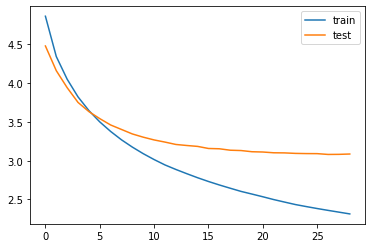

In [47]:
# loss 그래프 출력
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

29 epochs에서 early stopping 했다.
5 epochs까지 train과 test모두 비슷한 정도로 크게 감소했다.
test의 경우10 epochs부터 완만하게 감소하는 반면에 train의 loss값은 같은 경향성을 그대로 이어서 급격하게 감소하는 경향을 볼 수 있다.

## 실제 결과와 요약문 비교

In [48]:
# 복원 작업을 위한 Dict 생성
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('Done')

Done


In [49]:
# inference 모델 구현
# seq2seq는 trian과 inference시의 모델이 다름
# 따라서 별도로 구현

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('Done')

Done


In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('Done')

Done


In [51]:
# 단어 시퀀스를 형성하는 함수 생성
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('Done')

Done


In [52]:
# 암호화 복호화 할 수 있는 함수 생성
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('Done')

Done


In [53]:
# 개의 예시를 불러와서 실제 요약과 예측된 요약을 출력한다.
for i in range(70, 75):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : reacting sexual harassment allegations filmmaker rajkumar hirani dia mirza said deeply distressed news hope due official enquiry conducted think would grossly unjust part speak know details added actress worked hirani sanju 
실제 요약 : sostoken deeply dia mirza on hirani sexual harassment row 
예측 요약 :  hirani denies allegations of sexual harassment allegations


원문 : amritsar train accident dussehra celebrations friday year old mother said found body civil hospital mobile phone worth wallet gold chain missing another survivor lost three year old daughter said robbed phone shouting help daughter critically injured son 
실제 요약 : sostoken injured dead were robbed after amritsar train accident 
예측 요약 :  my mother family of family died in train accident


원문 : shraddha kapoor playing female lead choreographer filmmaker remo souza upcoming dance film katrina kaif exit per reports katrina spokesperson said decided step film dates clashing bharat currently shooting film also star varun dhawan

### 분석

#### Case 1
요약: deeply dia mirza on hirani sexual harassment row
예측: hirani denies allegations of sexual harassment allegations

- sexual harassment
- dia mirza

'hirani'의 의미가 잘못 사용된 것으로 보인다.

#### Case 2
요약: injured dead were robbed after amritsar train accident 
예측: my mother family of family died in train accident

- train accident
- dead (died)

'robbed', 'amritsar' 같은 주요 키워드가 없고, 'my mother'같은 불필요한 키워드나 'family of family' 같은 의문의 단어가 있음

#### Case 3
요약 : shraddha to star in remo dance film post katrina exit report 
예측 : shahid kapoor to star in shahid kapoor next film reports

- to star
- reports

사실상 예측에 실패한 것으로 보인다 또한 'shahid kapoor'가 사람으로 쓰였다가 in과 함께 장소로 쓰였다.

#### Case 4 
요약 : tribunal puts up startup stayzilla for sale 
예측 : anil ambani appointed as sebi member of sebi

- appointed (appointed) ; 유사성 있는 듯

'stayzilla'와 같은 중요 고유명사도 없고 알수 없는 'sebi'라는 단어가 반복되었다.
사실상 실패로 보인다.

#### Case 5
실제 요약 : farmers march in delhi demanding loan waivers better prices 
예측 요약 : farmers protest against delhi farmers for protest

- farmers
- protest (march)
- delhi

최소한의 주요 키워드는 확보했다.
하지만 왜 항의 또는 행진 했는지에 대한 언급 예측에 없다.

#### 결론
평균 2개의 단어가 포함되고 종종 유의어가 사용되었다.
좀 더 학습시키면 좋은 결과가 나올것이라고 생각한다.

## Summa 이용
문법 완성도 비교
핵심단어 포함
표로 정리

In [91]:
# 대표적인 추출 요약기 가져오기
from summa.summarizer import summarize

In [92]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [98]:
# 위와 같은 방법으로 일괄 요약
for i in range(70, 75):
#     _text = seq2text(encoder_input_test[i])
    _text = data.iloc[i,1]
    print("원문 :", _text)
    print("실제 요약 : ", data.iloc[i,0])
    print("예측 요약 : ", summarize(_text, ratio=0.35)) # ratio안달면 결과 안나옴...
    print("\n")

원문 : Apple CEO Tim Cook said the company plans to lower some iPhones' prices in markets with currencies that weakened against the US dollar in the past year. "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added. The price cuts, in hopes of increasing sales, are reportedly occurring for second time in 12 years.
실제 요약 :  Apple to cut some iPhones' prices outside US over strong dollar
예측 요약 :  "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.


원문 : Scientists in Australia's Flinders University are testing a wetsuit prototype that could protect its wearer after a shark attack. The suit, made of synthetic material similar to the material used in bulletproof vests, could help reduce blood loss after a shark attack. "The majority of fatalities from shark bites is due to blood loss...shock from blood loss," a scientist said.
실제 요약 :  Scientists test wetsuit to protect 

### 결과 분석

#### Case 1
실제 요약 :  Apple to cut some iPhones' prices outside US over strong dollar
예측 요약 :  "WeÃ¢ÂÂve decided to go back to (iPhone prices) more commensurate with...local prices...a year ago," Cook added.

해당 예측 요약은 뒷 문단이다. 게다가 첨언 느낌으로 팀쿡이 한 인용구를 그대로 출력했다. 하지만 그 인용구에 가격을 줄인다는 언급이 들어 있다. 

#### Case 2
실제 요약 :  Scientists test wetsuit to protect wearer after shark attack
예측 요약 :  "The majority of fatalities from shark bites is due to blood loss...shock from blood loss," a scientist said.

이번에도 불필요한 인용구를 요약이라고 뽑았다.
상어의 공격과 출혈을 주 기능이라고 언급해서 유사도가 아에 없지는 않지만
높은 평가를 주긴 힘들다.

#### Case 3
실제 요약 :  Come armed with sticks for PM Modi's rally in WB: BJP leader
예측 요약 :  BJP National Secretary Rahul Sinha on Wednesday asked the party workers in West Bengal to come armed with sticks to PM Narendra Modi's rally in the state on February 2.

수요일이라는 정보는 중요한 정보가 아니지만 요약에 포암되었다.
이번 케이스의 경우, 내용이 포함되었지만, 불필요한 살이 너무 많다.

#### Case 4
실제 요약 :  '4B' for Opposition is 'Bua-Bhatija-Bhai-Behen': Amit Shah
예측 요약 :  BJP President Amit Shah on Wednesday took a dig at the Opposition parties saying that the 'mahagathbandhan' for the Opposition is 4B - "Bua-Bhatija-Bhai-Behen".

주요 키워드인 '4B'와 'Bua-Bhatija-Bhai-Behen'가 포함되어 있지만, 과연 다른 문장들이 붙을 필요가 있었을까 생각한다.

#### Case 5
실제 요약 :  Volkswagen retains top spot in global sales, beats Toyota
예측 요약 :  Volkswagen's sales, including its MAN and Scania heavy trucks and buses, rose 0.9% to 10.83 million in 2018, the company had said.

주요 키워드인 'Volkswagen', 'sales'가 보인다. 
수치로서 증가했음을 보여서 의미적으로 실제 요약과의 유사성을 보여주지만, 요약일까?


## 비교 분석

노드의 요구에 따라 비교 분석을 해보는 시간을 가졌다.
나는 이전 과정에서 객관적인 지표 대신 주관적인 지표를 통해 일부 샘플을 분석했고 이것을 토대로 비교를 진행할 것이다.

| 비교 항복 | Extractive 요약 | Abstractive  요약 |
| --------- | --------------- | ----------------- |
| 단어 유사도 | 직접적으로 키워드가 포함되지 않음 | 키워드가 1~3개 포함됨 |
| 의미 단어 유사도 | 대체로 그럴싸한 문장 | 의미가 잘못된 경우도 많다. |
| 문장 길이 | 요약이라고 보기엔 길다. | 짧고 간결하다. |
| 불필요한 단어 포함 | 인용구를 주로 가져오는 것으로 보인다. | 의미를 알 수 없는 단어 사용이 간혹 보인다. |
| 정확도 | 평타는 친다. | 요약문 만으로 내용을 파악하기 힘들다. |

### 결론
**Extractive 요약**
원문에서 스크랩 해오는 느낌으로 진행하며, 주로 인용구를 가져온다.
의미는 일치 또는 유사하지만, 불필요한 단어가 많았다.

**Abstractive  요약**
요약으로서는 적절하고 키워드를 잘 탐색한다는 전재하에 고성능일 것으로 예측된다.
다만, 현재 모델이 부족해서 많은 키워드를 캐치하지 못했고, 일부 단어는 상상으로 만들어낸 것이라는 생각이 들 정도로 알 수 없는 문장이 발생했다.

어느쪽이든 좋지만, 잘 학습시킨 모델을 쓰는 것이 최상의 선택으로 보인다.

